# Intelligent denoising of Tailored MR Fingerprinting data 

## Qimin Zhang and Weiwei Qi

## 1. Config

In [51]:
import numpy as np
import os
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.regularizers import l1
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras

import matplotlib.pyplot as plt
import pandas as pd
from keras.utils.vis_utils import plot_model

from PIL import Image, ImageOps

import torch

from keras import models

import scipy.io as sio

# from dfply import *

torch.manual_seed(4460)
np.random.seed(4460)

In [29]:
import tensorflow as tf
print("Num CPUs Available: ", len(tf.config.experimental.list_physical_devices('CPU')))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num CPUs Available:  1
Num GPUs Available:  1


In [33]:
config = tf.compat.v1.ConfigProto(device_count = {'GPU': 1 , 'CPU': 1}) 
sess = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(sess)

In [35]:
import tensorflow as tf
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

## 2. Read data and explore

In [41]:
xtrain = scipy.io.loadmat('./data/xtrain.mat')
ytrain = scipy.io.loadmat('./data/ytrain.mat')

In [6]:
assert len(xtrain['TMRF_T2']) == len(ytrain['GS_T2'])
print('The sample size is', len(xtrain['TMRF_T2']))

The sample size is 20


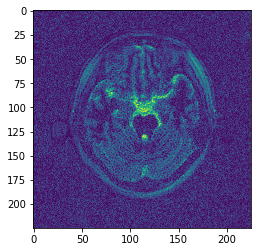

In [7]:
# Show the first image in xtrain
plt.imshow(xtrain['TMRF_T2'][1])    
plt.show()

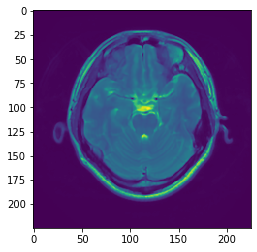

In [8]:
# Show the first image in ytrain
plt.imshow(ytrain['GS_T2'][1])    
plt.show()

(224, 224)


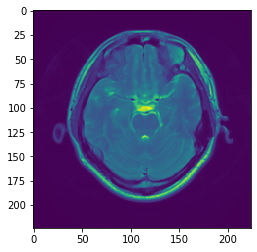

In [9]:
# With crop

print(ytrain['GS_T2'][1][0:224,0:224].shape)
plt.imshow(ytrain['GS_T2'][1][0:224,0:224])    
plt.show()

## 3. Define the model

In [36]:
# Define from keras

def unet(pretrained_weights=None, input_size=(224, 224, 1)):
    inputs = Input(input_size)
    # conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    # conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    # pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    # conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    # conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    conv7 = Conv2D(256, 1, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 1, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    # up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
    #     UpSampling2D(size=(2, 2))(conv7))

    # up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
    #     UpSampling2D(size=(2, 2))(conv7))
    up8 = Conv2D(128, 1, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)

    # conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 1, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    # conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
    conv8 = Conv2D(128, 1, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    # up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
    #     UpSampling2D(size=(2, 2))(conv8))
    # merge9 = concatenate([conv1, up9], axis=3)
    # conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    # conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    # conv9 = Conv2D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)


    # conv10 = Conv2D(1, 1, kernel_regularizer=l1(0.0001))(conv8)
    conv10 = Conv2D(1, 1)(conv8)

    model = Model(input=inputs, output=conv10)
    model.compile(optimizer=Adam(lr=1e-4), loss='mse',  metrics=['mae', 'mse'])
    print(model.summary())

    if (pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

## 4. Train the model

In [42]:
xtrain = xtrain['TMRF_T2'][:, 0:224, 0:224]
ytrain = ytrain['GS_T2'][:, 0:224, 0:224]

xtrain = np.reshape(xtrain, [20, 224, 224, 1])
ytrain = np.reshape(ytrain, [20, 224, 224, 1])

print(len(xtrain))
print(len(ytrain))

20
20


In [ ]:
from keras.callbacks import EarlyStopping

# Define paths
checkpoint_path = "./saved_models/unet.hdf5"


# Define model hyperparameters
EPOCHS = 80
SPEREPOCH = 20


# Setup definitions for display
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error')
    plt.plot(hist['epoch'], hist['loss'],
             label='Train Error')
    plt.plot(hist['epoch'], hist['mae'],
             label='Val Error')
    plt.ylim([0, 500])
    plt.legend()
    plt.show()


model = unet()

# plot_model(model, to_file='model_plot.png')

# model_checkpoint = ModelCheckpoint('unet_pepa.hdf5', monitor='loss',verbose=1, save_best_only=True)
# cp_callback =  ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True,verbose=1,save_best_only=True)
# cp_callback = ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1)

# cp_callback = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_best_only=False,
#                               save_weights_only=True, mode='auto', period=1)

cp_callback = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_best_only=False,
                              save_weights_only=True, mode='auto', period=5)

#es = EarlyStopping(monitor='val_loss', mode='min', baseline=0.4)

callbacks_list = [cp_callback]
history = model.fit(
    xtrain, ytrain, 
    #steps_per_epoch=SPEREPOCH,
    epochs=EPOCHS, callbacks=callbacks_list, verbose=1, batch_size=10)
print('Training done')

/home/zhangqimin17/anaconda3/envs/BMEN4460/lib/python3.7/site-packages/ipykernel_launcher.py:63: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 224, 224, 1)  0                                            
__________________________________________________________________________________________________
conv2d_145 (Conv2D)             (None, 224, 224, 128 1280        input_9[0][0]                    
__________________________________________________________________________________________________
conv2d_146 (Conv2D)             (None, 224, 224, 128 147584      conv2d_145[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_25 (MaxPooling2D) (None, 112, 112, 128 0           conv2d_146[0][0]                 
____________________________________________________________________________________________

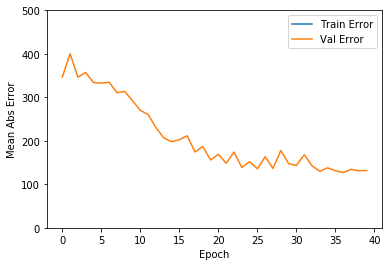

ImportError: Failed to import `pydot`. Please install `pydot`. For example with `pip install pydot`.

In [52]:
history_save = {'loss': history.history['loss'], 'mae': history.history['mae'], 'mse': history.history['mse']}
sio.savemat('./history_invcor.mat', history_save)
plot_history(history)

# VISUALIZATION
plot_model(model, to_file='model_plot_invcor.png', show_shapes=True, show_layer_names=True)
# layer_outputs = [layer.output for layer in model.layers[:1]]
layer_outputs = [layer.output for layer in model.layers]

activation_model = models.Model(inputs=model.input,
                                outputs=layer_outputs)  # Creates a model that will return these outputs, given the model input
activations = activation_model.predict(xtest_vis)

first_layer_activation = activations[29]
print(first_layer_activation.shape)
plt.matshow(first_layer_activation[0, :, :, 0], cmap='viridis')
plt.show()

dictOfactivations = {'Layer'+str(i): activations[i] for i in range(0, len(activations))}
sio.savemat('./Lactivations_invcor.mat', dictOfactivations)

# TESTING
ypred = model.predict(xtrain, verbose=1)
result = {'ypred_invcor': ypred, 'ytrain_deblur': ytrain}
sio.savemat('./TMRF_128_invcor.mat', result)

In [53]:
# TESTING
ypred = model.predict(xtrain, verbose=1)
result = {'ypred_invcor': ypred, 'ytrain_deblur': ytrain}
sio.savemat('./TMRF_128_invcor.mat', result)

20/20 [==============================] - 2s 79ms/step


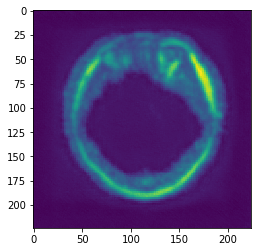

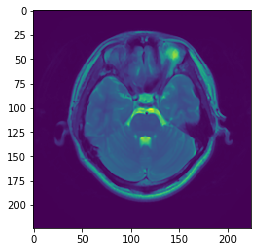

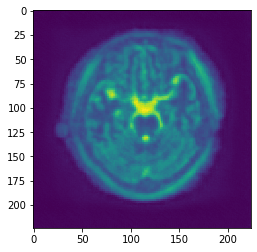

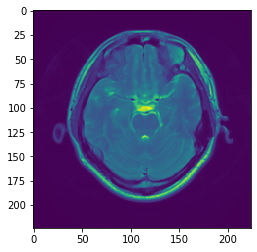

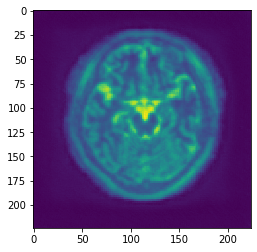

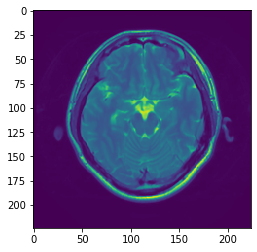

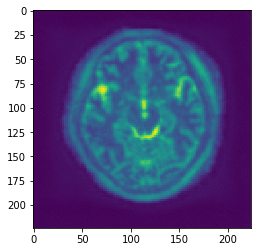

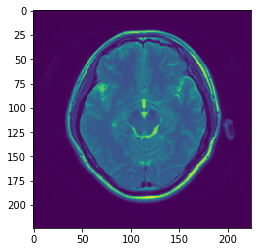

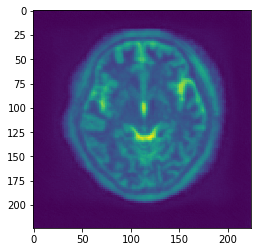

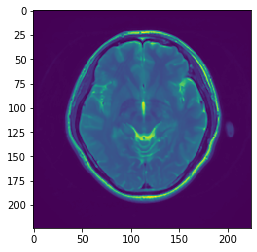

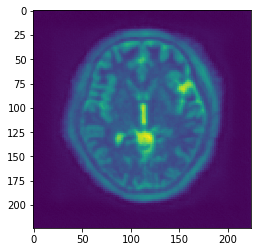

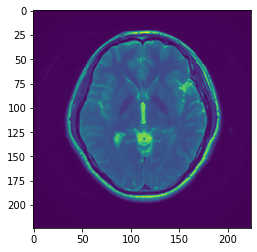

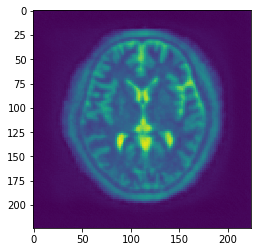

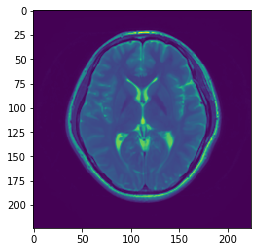

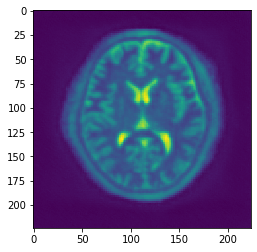

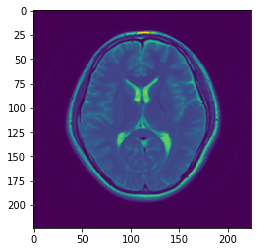

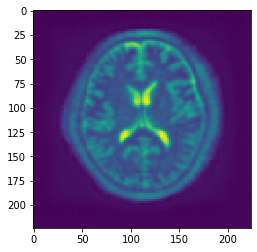

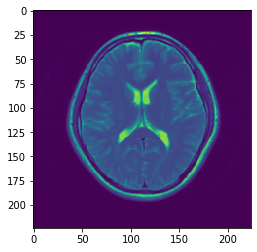

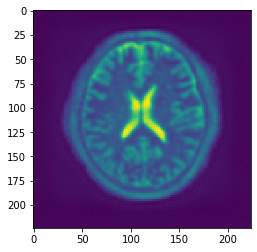

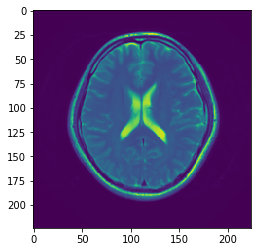

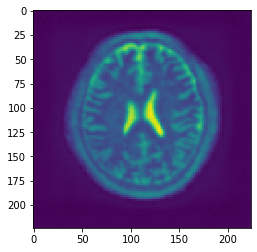

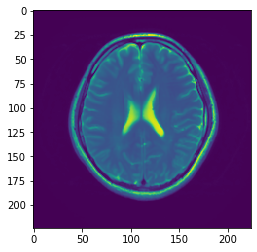

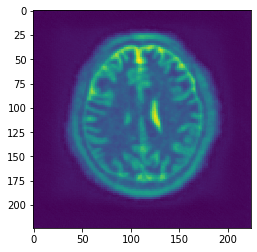

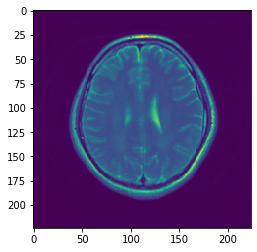

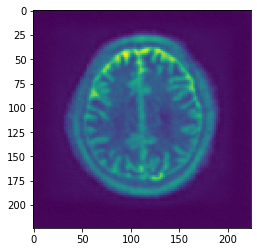

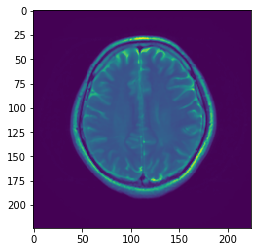

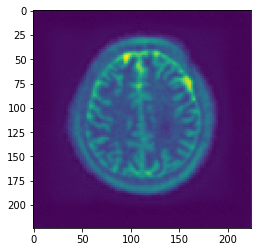

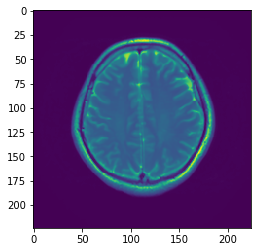

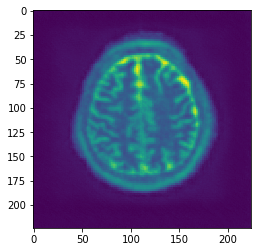

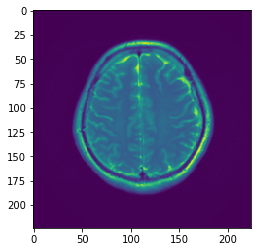

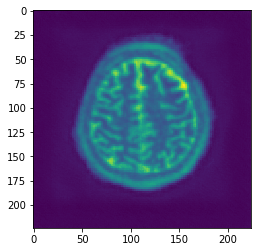

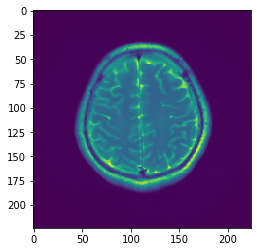

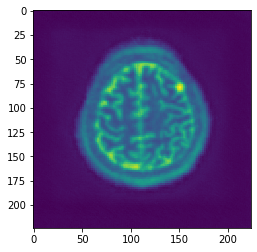

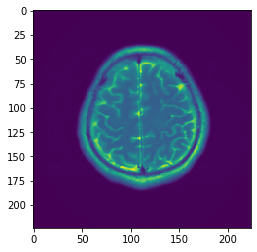

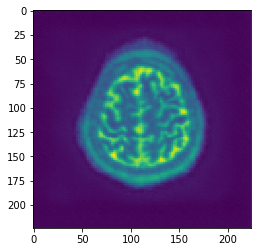

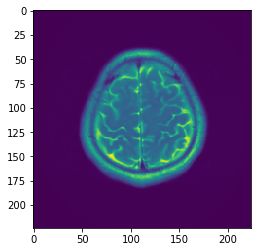

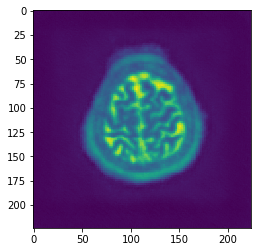

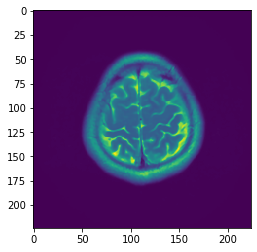

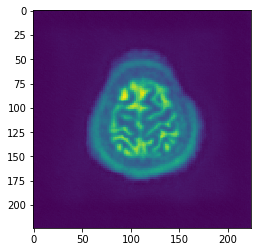

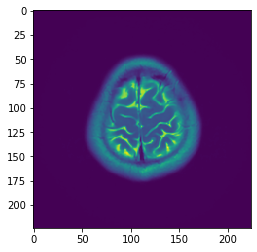

In [55]:
for i in range(10):
    plt.imshow(result['ypred_invcor'][i,:,:,0])    
    plt.show()
    plt.imshow(result['ytrain_deblur'][i,:,:,0])    
    plt.show()